# Plotting 

In [3]:
import os
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path


NUM_ITER = 1000
SCENE_NAME = "hotdog"
WITH_OCC = True


In [4]:
# --- 1. Data Collection and Aggregation ---

# Input directory containing the JSON files
input_dir = Path('./output/1027_with_occ/for_plot/')
# Output directory for aggregated JSONs and plots
output_dir = Path('output/exp1027_plots/')
output_dir.mkdir(parents=True, exist_ok=True)

files = sorted(glob(str(input_dir / '*.json')))
# policy -> list of {num_gs, psnr, ssim, lpips}
policy_data = defaultdict(list)

print(f"Found {len(files)} files in {input_dir}")

for fp in files:
    try:
        # Extract policy and budget from filename like 'area_131072.json'
        basename = os.path.basename(fp)
        policy, budget_str = basename.rsplit('_', 1)
        num_gs = int(budget_str.split('.')[0])

        with open(fp, 'r') as f:
            data = json.load(f)
        
        # The JSON has a structure like {"key": {"metric": value, ...}}
        # We get the first value from the top-level dictionary
        metrics = list(data.values())[0]
        
        psnr = metrics.get('PSNR')
        ssim = metrics.get('SSIM')
        lpips = metrics.get('LPIPS')

        if all(v is not None for v in [psnr, ssim, lpips]):
            policy_data[policy].append({
                "policy_name": policy,
                "num_gs": num_gs,
                "psnr": float(psnr),
                "ssim": float(ssim),
                "lpips": float(lpips)
            })
        else:
            print(f"Skipping {fp}: Missing one or more metrics.")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# --- 2. Save Aggregated Data to JSON Files ---

policies = sorted(policy_data.keys())
print(f"\nFound policies: {policies}")

for policy in policies:
    # Sort data by num_gs before saving
    sorted_data = sorted(policy_data[policy], key=lambda x: x['num_gs'])
    output_json_path = output_dir / f'{policy}_aggregated.json'
    with open(output_json_path, 'w') as f:
        json.dump(sorted_data, f, indent=2)
    print(f"Saved aggregated data to {output_json_path}")
    
# example shape
example_shape = (len(policy_data[policies[0]]),)
print(f"Example shape of aggregated data for policy '{policies[0]}': {example_shape}")


Found 33 files in output/1027_with_occ/for_plot

Found policies: ['area', 'planarity_hop1', 'rand_uni']
Saved aggregated data to output/exp1027_plots/area_aggregated.json
Saved aggregated data to output/exp1027_plots/planarity_hop1_aggregated.json
Saved aggregated data to output/exp1027_plots/rand_uni_aggregated.json
Example shape of aggregated data for policy 'area': (11,)



Figure saved to output/exp1027_plots/psnr_vs_numgs.png


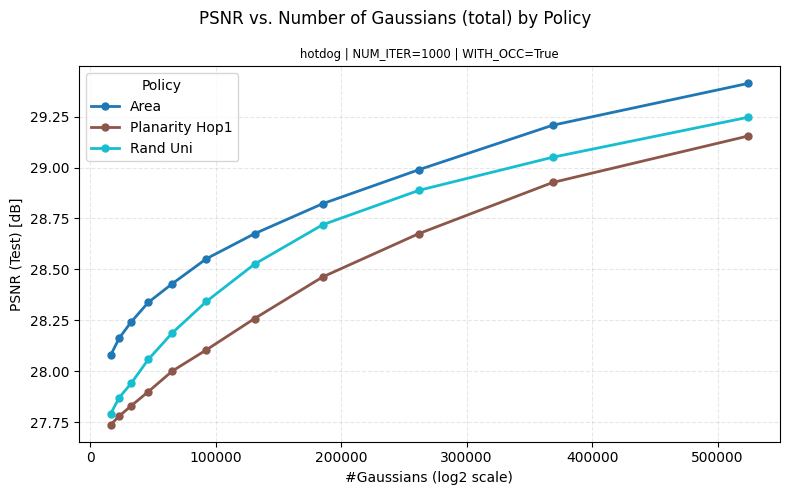


Figure saved to output/exp1027_plots/ssim_vs_numgs.png


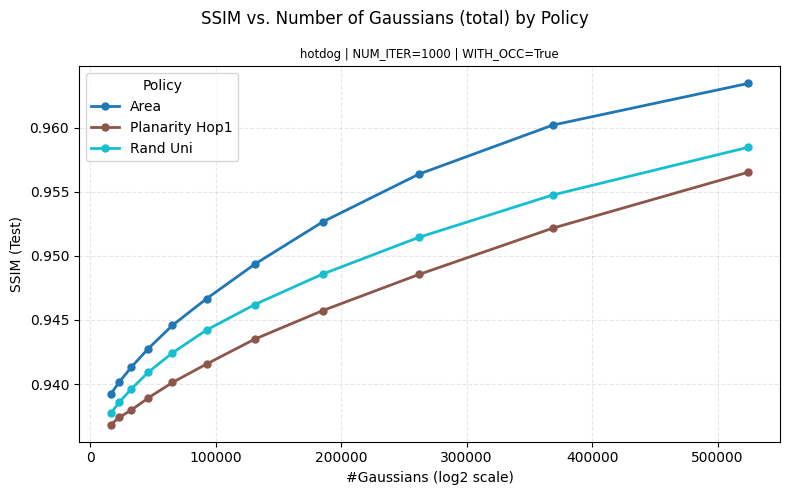


Figure saved to output/exp1027_plots/lpips_vs_numgs.png


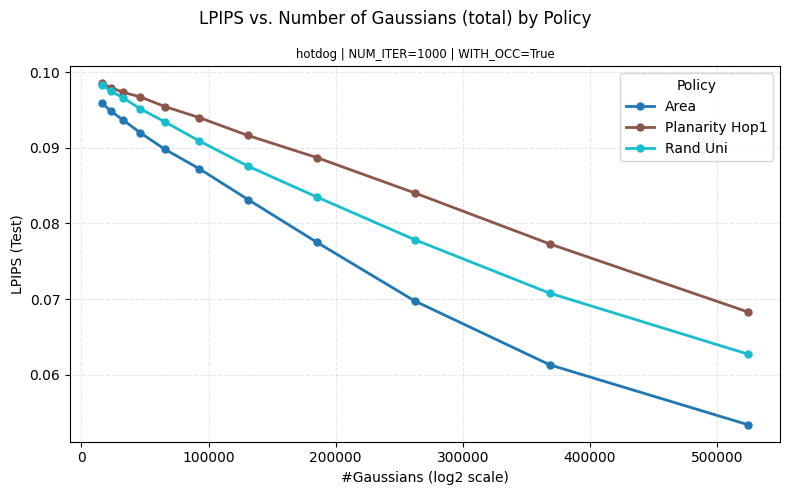

In [ ]:
# --- 3. Plotting ---

if not policies:
    print("\nNo data found to plot!")
else:
    metrics_to_plot = {
        "PSNR": {"unit": "dB", "label": "PSNR (Test) [dB]"},
        "SSIM": {"unit": "", "label": "SSIM (Test)"},
        "LPIPS": {"unit": "", "label": "LPIPS (Test)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        
        for policy, color in zip(policies, colors):
            records = policy_data[policy]
            if not records:
                continue

            # Sort by num_gs to ensure lines are drawn correctly
            records.sort(key=lambda r: r['num_gs'])
            
            xs = np.array([r['num_gs'] for r in records])
            ys = np.array([r[metric_key.lower()] for r in records])
            
            # Ensure positive x values for log scale
            xs_plot = np.maximum(xs, 1)
            
            ax.plot(xs_plot, ys, 'o-', linewidth=2, markersize=5, 
                    color=color, label=policy.replace('_', ' ').title())
        
        # try:
        #     ax.set_xscale('log', base=2)
        # except TypeError:
        #     ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        # ax.set_xlabel('#Gaussians (log2 scale)')
        ax.set_xlabel('#Gaussians')
        
        ax.set_ylabel(metric_info["label"])
        fig.suptitle(f'{metric_key} vs. Number of Gaussians (total) by Policy')
        ax.set_title(f'{SCENE_NAME} | NUM_ITER={NUM_ITER} | WITH_OCC={WITH_OCC}', fontsize='small')
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title='Policy')
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_vs_numgs.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"\nFigure saved to {output_fig_path}")
        
        plt.show()

# Entropy Image

In [21]:
from skimage import io, color
from skimage.filters import rank
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np

# load image and convert to grayscale, 8-bit
img = io.imread("data/dynerf/test_yc_mesh/mesh_000.png")

# Check if the image has an alpha channel (4 channels) and remove it if present
if img.shape[-1] == 4:
    img = img[..., :3]

gray = color.rgb2gray(img)
gray_ubyte = (gray * 255).astype(np.uint8)

# compute local entropy with a disk-shaped neighborhood
entropy_img = rank.entropy(gray_ubyte, disk(5))
# disk() value can be adjusted

# overall complexity score = mean entropy
complexity = np.mean(entropy_img)
print("Spatial complexity (entropy):", complexity)

# show result
plt.imshow(entropy_img, cmap="magma")
plt.colorbar()
plt.show()

ModuleNotFoundError: No module named 'skimage'